# Building a PhotonicDevice

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import imodulator
import shapely
import openbandparams as obp
from imodulator.ElectroOpticalModel import InGaAsPElectroOpticalModel

%matplotlib inline

Successfully imported lumapi


Building a `PhotonicDevice` is where you, as a designer, will be spending the majority of your time. It is a very tedius and cumbersome task, as you have to get all the material parameters right as well as the geometry. Luckily, with the `Imodulator` you only have to do this once. While using this software, we have found it easier to to wrap the creation of the `PhotonicDevice` in a python class, but feel free to do as you see fit. 

For educational purposes, we will build the class `InP_EOPM` in a very inneficient way, but bear with us. Our goal is to simulate the following:

<div style="text-align: center;">
  <img src="support/parametrization.png" alt="Alt text" style="max-width: 80%; height: auto;">
</div>

For the optical refractive indices and dielectric constants of the InGaAsP alloys, we will use `openbandparams`. 

Before we go to the geometry, we shall define all the mesh settings. For the full workflow of designing a modulator, we must handle 4 meshes: optical mode solver, poisson-drift-diffusion solver, RF solver and electro-optic calculations

In [2]:
def tand_fitted_bcb(x):
    """
    Fitted to results from https://link.springer.com/article/10.1007/s10762-009-9552-0
    
    x must be in GHz
    """
    out =  0.0093839 - 0.01790336 * np.exp(-0.04773444 * (x - -4.64170761))

    if isinstance(x, (list, np.ndarray)):
        x = np.asarray(x)
    
        out[np.where(out<0.001)] = 0.001
    else:
        if out < 0.001:
            out = 0.001
    return out

class InP_EOPM:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

Now that we have all the mesh settings, we shall create the geometry which is handled by `shapely`

In [ ]:
def _create_polygons(self):
    #We will now set the RF properties of the metals and the BCB
    freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
    eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)
    eps_rf_metal = np.asarray([freq, eps_rf_metal])
    
    bcb_eps_real = 2.65*np.ones(100)
    bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

    bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
    bcb_eps = np.asarray([freq, bcb_eps])
    
    #Now we create the PhotoPolygons
    self.substrate = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_window/2,
            -self.h_box - self.h_bottom,
            self.w_window/2,
            -self.h_box
        ),
        rf_eps = 11.7,
        name = 'substrate',
        optical_material=3**2,
        eo_mesh_settings=self.eo_mesh_settings['substrate'],
        rf_mesh_settings=self.rf_mesh_settings['substrate'],
        optical_mesh_settings=self.optical_mesh_settings['substrate'],
    )

    self.background = imodulator.InsulatorPolygon(
        shapely.box(
            -self.w_window/2,
            -self.h_box - self.h_bottom,
            self.w_window/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
        ),
        rf_eps = 1,
        optical_material=1,
        eo_mesh_settings=self.eo_mesh_settings['background'],
        rf_mesh_settings=self.rf_mesh_settings['background'],
        optical_mesh_settings=self.optical_mesh_settings['background'],
        name = 'background'
    )

    self.box = imodulator.InsulatorPolygon(
        shapely.box(
            -self.w_window/2,
            -self.h_box,
            self.w_window/2,
            0
        ),
        rf_eps = 3.9 - 1j*3.9*0.001,
        optical_material=1.44**2,
        eo_mesh_settings=self.eo_mesh_settings['box'],
        rf_mesh_settings=self.rf_mesh_settings['box'],
        optical_mesh_settings=self.optical_mesh_settings['box'],
        name = 'box'
    )

    n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
    self.n = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
            0,
            self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
            self.h_n
        ),
        rf_eps = n_obp_material.dielectric(T=300),
        optical_material=n_obp_material.refractive_index(T=300)**2,
        eo_mesh_settings=self.eo_mesh_settings['n'],
        rf_mesh_settings=self.rf_mesh_settings['n'],
        optical_mesh_settings=self.optical_mesh_settings['n'],
        charge_mesh_settings=self.charge_mesh_settings['n'],
        name = 'n',
        electro_optic_module=InGaAsPElectroOpticalModel,
        electro_optic_module_kwargs={
            'y': 0,
            'T': 300,
            'BF_model': 'vinchant'
        },
        charge_transport_simulator_kwargs={
            'sol_obp_material': n_obp_material,
            'sol_Nd': 1e18
        }
    )

    wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
    self.wg1 = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_wg/2,
            self.h_n,
            self.w_wg/2,
            self.h_n + self.h_wg1
        ),
        rf_eps = wg1_obp_material.dielectric(T=300),
        optical_material=wg1_obp_material.refractive_index(T=300)**2,
        eo_mesh_settings=self.eo_mesh_settings['wg1'],
        rf_mesh_settings=self.rf_mesh_settings['wg1'],
        optical_mesh_settings=self.optical_mesh_settings['wg1'],
        charge_mesh_settings=self.charge_mesh_settings['wg1'],
        name = 'wg1',
        electro_optic_module=InGaAsPElectroOpticalModel,
        electro_optic_module_kwargs={
            'y': 0.53,
            'T': 300,
            'BF_model': 'vinchant'
        },
        charge_transport_simulator_kwargs={
            'sol_obp_material': wg1_obp_material,
            'sol_Nd': 1e16
        }
    )

    wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
    self.wg2 = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_wg/2,
            self.h_n + self.h_wg1,
            self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2
        ),
        rf_eps = wg2_obp_material.dielectric(T=300),
        optical_material=wg2_obp_material.refractive_index(T=300)**2,
        eo_mesh_settings=self.eo_mesh_settings['wg2'],
        rf_mesh_settings=self.rf_mesh_settings['wg2'],
        optical_mesh_settings=self.optical_mesh_settings['wg2'],
        charge_mesh_settings=self.charge_mesh_settings['wg2'],
        name = 'wg2',
        electro_optic_module=InGaAsPElectroOpticalModel,
        electro_optic_module_kwargs={
            'y': 0,
            'T': 300,
            'BF_model': 'vinchant'
        },
        charge_transport_simulator_kwargs={
            'sol_obp_material': wg2_obp_material,
            'sol_Nd': 1e16
        }
    )

    p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
    self.p1 = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2,
            self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
        ),
        rf_eps = p1_obp_material.dielectric(T=300),
        optical_material=p1_obp_material.refractive_index(T=300)**2,
        eo_mesh_settings=self.eo_mesh_settings['p1'],
        rf_mesh_settings=self.rf_mesh_settings['p1'],
        optical_mesh_settings=self.optical_mesh_settings['p1'],
        charge_mesh_settings=self.charge_mesh_settings['p1'],
        name = 'p1',
        electro_optic_module=InGaAsPElectroOpticalModel,
        electro_optic_module_kwargs={
            'y': 0,
            'T': 300,
            'BF_model': 'vinchant'
        },
        charge_transport_simulator_kwargs={
            'sol_obp_material': wg2_obp_material,
            'sol_Na': 1e17
        }
    )

    p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
    self.p2 = imodulator.SemiconductorPolygon(
        shapely.box(
            -self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
            self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
        ),
        rf_eps = p2_obp_material.dielectric(T=300),
        optical_material=p2_obp_material.refractive_index(T=300)**2,
        eo_mesh_settings=self.eo_mesh_settings['p2'],
        rf_mesh_settings=self.rf_mesh_settings['p2'],
        optical_mesh_settings=self.optical_mesh_settings['p2'],
        charge_mesh_settings=self.charge_mesh_settings['p2'],
        name = 'p2',
        electro_optic_module=InGaAsPElectroOpticalModel,
        electro_optic_module_kwargs={
            'y': 0,
            'T': 300,
            'BF_model': 'vinchant'
        },
        charge_transport_simulator_kwargs={
            'sol_obp_material': p2_obp_material,
            'sol_Na': 1e19
        }
    )

    self.bcb_far_left = imodulator.InsulatorPolygon(
        shapely.box(
            -self.w_window/2,
            0,
            -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
        ),
        rf_eps = bcb_eps,
        optical_material=1.56**2,
        eo_mesh_settings=self.eo_mesh_settings['bcb'],
        rf_mesh_settings=self.rf_mesh_settings['bcb'],
        optical_mesh_settings=self.optical_mesh_settings['bcb'],
        name = 'bcb_far_left'
    )

    self.bcb_far_right = imodulator.InsulatorPolygon(
        shapely.box(
            self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
            0,
            self.w_window/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
        ),
        rf_eps = bcb_eps,
        optical_material=1.56**2,
        eo_mesh_settings=self.eo_mesh_settings['bcb'],
        rf_mesh_settings=self.rf_mesh_settings['bcb'],
        optical_mesh_settings=self.optical_mesh_settings['bcb'],
        name = 'bcb_far_right'
    )

    self.bcb_left = imodulator.InsulatorPolygon(
        shapely.box(
            -self.w_sig_metal/2 - self.metal_sep,
            self.h_n,
            -self.w_wg/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
        ),
        rf_eps = bcb_eps,
        optical_material=1.56**2,
        eo_mesh_settings=self.eo_mesh_settings['bcb'],
        rf_mesh_settings=self.rf_mesh_settings['bcb'],
        optical_mesh_settings=self.optical_mesh_settings['bcb'],
        name = 'bcb_left'
    )

    self.bcb_right = imodulator.InsulatorPolygon(
        shapely.box(
            self.w_wg/2,
            self.h_n,
            self.w_sig_metal/2 + self.metal_sep,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
        ),
        rf_eps = bcb_eps,
        optical_material=1.56**2,
        eo_mesh_settings=self.eo_mesh_settings['bcb'],
        rf_mesh_settings=self.rf_mesh_settings['bcb'],
        optical_mesh_settings=self.optical_mesh_settings['bcb'],
        name = 'bcb_right'
    )

    self.sig_metal = imodulator.MetalPolygon(
        shapely.box(
            -self.w_sig_metal/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2,
            self.w_sig_metal/2,
            self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal
        ),
        rf_eps = eps_rf_metal,
        eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
        rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
        optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
        name = 'sig_metal',
        calculate_current=True,
        d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
    )

    self.n_metal_left = imodulator.MetalPolygon(
        shapely.box(
            -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
            self.h_n,
            -self.w_sig_metal/2 - self.metal_sep,
            self.h_n + self.h_metal
        ),
        rf_eps = eps_rf_metal,
        eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
        rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
        optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
        name = 'n_metal_left',
        calculate_current=False
    )

    self.n_metal_right = imodulator.MetalPolygon(
        shapely.box(
            self.w_sig_metal/2 + self.metal_sep,
            self.h_n,
            self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
            self.h_n + self.h_metal
        ),
        rf_eps = eps_rf_metal,
        eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
        rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
        optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
        name = 'n_metal_right',
        calculate_current=False
    )


InP_EOPM._create_polygons = _create_polygons

eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()

Now that we have created all the polygons, we can initialize our device. A very important aspect to consider is hierarchy. When meshing, the algorithms must now which boundaries to prioritize over others, and of there are overlapping polygons, then we need to know which to keep and which to exclude. The way we do this is through a list. The top elements have priority over bottom elements. We haven't quite figured out what is the proper rule to put polygons, but our reccomendations are:

- Always put metal polygons on top. This will ensure that RF calculations have the metalic boundaries well defined.
- Put the semiconductor structures in a way that makes sense. That is, in our case, we have a vertical structure, so we will place all the polygons from top to bottom.
- Prioritize semiconductor over insulator polygons.
- It is mandatory to always include a background polygon. If you don't include it we will create it for you internally. But might as well create it yourself, so that you can control how far away the simulation boundaries are.
- Always put the background with least priority.
- When doing RF simulations, you can flag `MetalPolygon` with `calculate_current`. By doing so, we will be including in the mesh a line with which we will integrate the magnetic field for current calculations. Any line that is created is put as top priority.
- Always make sure you have no empty polygons.

It is possible that you get some error due to this hierarchy. Sadly the error messages stemming from `gmsh` will not be very clear, so make sure you try various sensible configurations until you have something that is meshed.

In [4]:
def _initialize_device(self):
    photo_polygons = [
        self.sig_metal,
        self.n_metal_left,
        self.n_metal_right,
        self.p2,
        self.p1,
        self.wg2,
        self.wg1,
        self.n,
        self.box,
        self.bcb_left,
        self.bcb_right,
        self.bcb_far_left,
        self.bcb_far_right,
        self.substrate,
        self.background
    ]
    
    #Just in case there are empty polygons
    idxs_to_remove = []
    for i, poly in enumerate(photo_polygons):
        if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
            idxs_to_remove.append(i)
    for i in idxs_to_remove[::-1]:
        del photo_polygons[i]
    self.device = imodulator.PhotonicDevice(
        photo_polygons
    )

InP_EOPM._initialize_device = _initialize_device
eopm = InP_EOPM()
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

And we're **DONE**. Now we can inspect our device

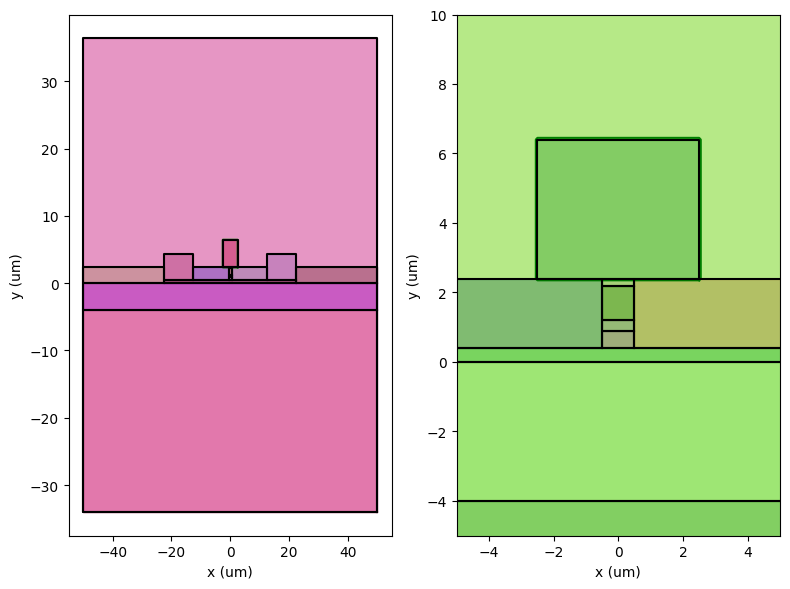

In [5]:
fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()

For the moment we cannot check how the physical properties look like. But we will be able to do once we start working with the different simulators.

Because we deal with shapely, it is possible to have arbitrary shapes with each polygon as well:

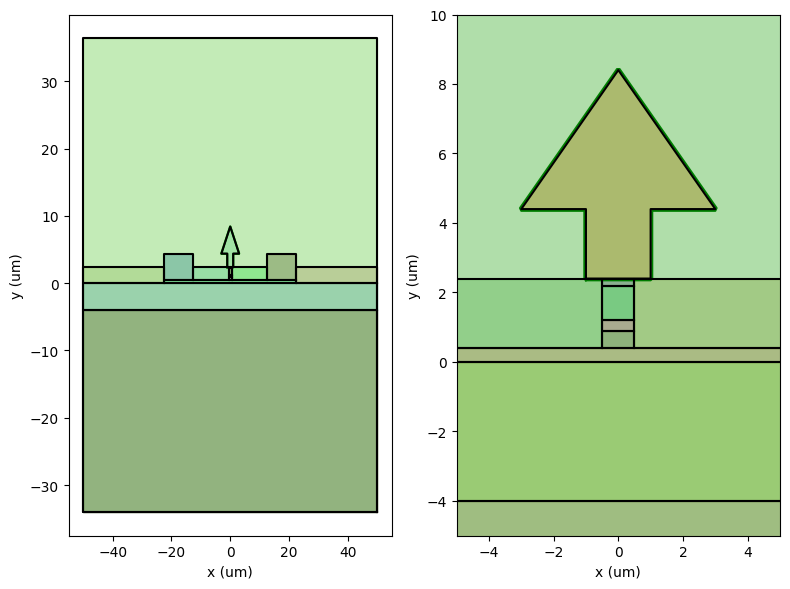

: 

In [ ]:
class InP_EOPM_tree:
    def __init__(
            self,
            **kwargs
    ):
        
        self.e = 1.60e-19 # electron charge in C
        self.e0 = 8.85e-12 # vacuum permittivity in F/m
        
        self.w_sig_metal = 5 # Width of signal metal in um
        self.metal_sep = 10 # Separation between signal and ground metals in um
        self.h_metal = 4 # Height of metals in um
        self.w_gnd_metal = 10
        
        self.w_wg = 1
        self.h_n = 0.4
        self.h_wg1 = 0.5
        self.h_wg2 = 0.3
        self.h_p1 = 1
        self.h_p2 = 0.2

        self.h_box = 4

        self.w_window = 100
        self.h_bottom = 30
        self.h_top = 30

        self.base_tree = 10
        self.height_tree = 50
        self.width_tree = 20

        for kwarg, value in kwargs.items():
            if hasattr(self, kwarg):
                setattr(self, kwarg, value)
    
    def _make_meshes(self):
        # optical mesh
        self.optical_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        # RF mesh
        self.rf_mesh_settings = {
            'substrate': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'sig_metal': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_left': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'n_metal_right': {'resolution': 3, 'SizeMax': 3, 'distance': 0.1},
            'bcb': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 5, 'SizeMax': 5, 'distance': 0.1},
        }

        # eo mesh
        self.eo_mesh_settings = {
            'substrate': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'background': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'box': {'resolution': 0.3, 'SizeMax': 0.2, 'distance': 0.1},
            'sig_metal': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_left': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'n_metal_right': {'resolution': 10, 'SizeMax': 0.2, 'distance': 0.1},
            'bcb': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'n': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'wg1': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'wg2': {'resolution': 0.1, 'SizeMax': 5, 'distance': 0.1},
            'p1': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
            'p2': {'resolution': 0.5, 'SizeMax': 5, 'distance': 0.1},
        }

        self.charge_mesh_settings = {
            'substrate': {'resolution': 0.5},
            'background': {'resolution': 0.5},
            'sig_metal': {'resolution': 0.01},
            'n_metal_left': {'resolution': 0.01},
            'n_metal_right': {'resolution': 0.01},
            'n': {'resolution': 0.003},
            'wg1': {'resolution': 0.002},
            'wg2': {'resolution': 0.002},
            'p1': {'resolution': 0.003},
            'p2': {'resolution': 0.003},
        }

    def _create_polygons(self):
        #We will now set the RF properties of the metals and the BCB
        freq = np.linspace(0.1,100, 100) #GHz. This will be the simulation frequency
            
        eps_rf_metal = 1 - 1j*6e7/(2*np.pi*freq*1e9 * self.e0)

        bcb_eps_real = 2.65*np.ones(100)
        bcb_eps_imag = bcb_eps_real * tand_fitted_bcb(freq)

        bcb_eps = bcb_eps_real - 1j*bcb_eps_imag
        
        #Now we create the PhotoPolygons
        self.substrate = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                -self.h_box
            ),
            rf_eps = 11.7,
            name = 'substrate',
            optical_material=3**2,
            eo_mesh_settings=self.eo_mesh_settings['substrate'],
            rf_mesh_settings=self.rf_mesh_settings['substrate'],
            optical_mesh_settings=self.optical_mesh_settings['substrate'],
        )

        self.background = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box - self.h_bottom,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2 + self.h_metal + self.h_top
            ),
            rf_eps = 1,
            optical_material=1,
            eo_mesh_settings=self.eo_mesh_settings['background'],
            rf_mesh_settings=self.rf_mesh_settings['background'],
            optical_mesh_settings=self.optical_mesh_settings['background'],
            name = 'background'
        )

        self.box = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                -self.h_box,
                self.w_window/2,
                0
            ),
            rf_eps = 3.9 - 1j*3.9*0.001,
            optical_material=1.44**2,
            eo_mesh_settings=self.eo_mesh_settings['box'],
            rf_mesh_settings=self.rf_mesh_settings['box'],
            optical_mesh_settings=self.optical_mesh_settings['box'],
            name = 'box'
        )

        n_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.n = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                0,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n
            ),
            rf_eps = n_obp_material.dielectric(T=300),
            optical_material=n_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['n'],
            rf_mesh_settings=self.rf_mesh_settings['n'],
            optical_mesh_settings=self.optical_mesh_settings['n'],
            charge_mesh_settings=self.charge_mesh_settings['n'],
            name = 'n',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': n_obp_material,
                'sol_Nd': 1e18
            }
        )

        wg1_obp_material = obp.GaInPAs(T=300, As = 0.53, a = obp.InP.a())
        self.wg1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n,
                self.w_wg/2,
                self.h_n + self.h_wg1
            ),
            rf_eps = wg1_obp_material.dielectric(T=300),
            optical_material=wg1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg1'],
            rf_mesh_settings=self.rf_mesh_settings['wg1'],
            optical_mesh_settings=self.optical_mesh_settings['wg1'],
            charge_mesh_settings=self.charge_mesh_settings['wg1'],
            name = 'wg1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0.53,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg1_obp_material,
                'sol_Nd': 1e16
            }
        )

        wg2_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.wg2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2
            ),
            rf_eps = wg2_obp_material.dielectric(T=300),
            optical_material=wg2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['wg2'],
            rf_mesh_settings=self.rf_mesh_settings['wg2'],
            optical_mesh_settings=self.optical_mesh_settings['wg2'],
            charge_mesh_settings=self.charge_mesh_settings['wg2'],
            name = 'wg2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Nd': 1e16
            }
        )

        p1_obp_material = obp.GaInPAs(T=300, As = 0, a = obp.InP.a())
        self.p1 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1
            ),
            rf_eps = p1_obp_material.dielectric(T=300),
            optical_material=p1_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p1'],
            rf_mesh_settings=self.rf_mesh_settings['p1'],
            optical_mesh_settings=self.optical_mesh_settings['p1'],
            charge_mesh_settings=self.charge_mesh_settings['p1'],
            name = 'p1',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': wg2_obp_material,
                'sol_Na': 1e17
            }
        )

        p2_obp_material = obp.GaInAs(T=300, a = obp.InP.a())
        self.p2 = imodulator.SemiconductorPolygon(
            shapely.box(
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1,
                self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = p2_obp_material.dielectric(T=300),
            optical_material=p2_obp_material.refractive_index(T=300)**2,
            eo_mesh_settings=self.eo_mesh_settings['p2'],
            rf_mesh_settings=self.rf_mesh_settings['p2'],
            optical_mesh_settings=self.optical_mesh_settings['p2'],
            charge_mesh_settings=self.charge_mesh_settings['p2'],
            name = 'p2',
            electro_optic_module=InGaAsPElectroOpticalModel,
            electro_optic_module_kwargs={
                'y': 0,
                'T': 300,
                'BF_model': 'vinchant'
            },
            charge_transport_simulator_kwargs={
                'sol_obp_material': p2_obp_material,
                'sol_Na': 1e19
            }
        )

        self.bcb_far_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_window/2,
                0,
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_left'
        )

        self.bcb_far_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.metal_sep + self.w_gnd_metal + self.w_sig_metal/2,
                0,
                self.w_window/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_far_right'
        )

        self.bcb_left = imodulator.InsulatorPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n,
                -self.w_wg/2,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_left'
        )

        self.bcb_right = imodulator.InsulatorPolygon(
            shapely.box(
                self.w_wg/2,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2
            ),
            rf_eps = bcb_eps,
            optical_material=1.56**2,
            eo_mesh_settings=self.eo_mesh_settings['bcb'],
            rf_mesh_settings=self.rf_mesh_settings['bcb'],
            optical_mesh_settings=self.optical_mesh_settings['bcb'],
            name = 'bcb_right'
        )


        self.sig_metal = imodulator.MetalPolygon(
            shapely.Polygon(
                [
                    (-self.base_tree/2,0+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (-self.base_tree/2, self.base_tree+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (-self.width_tree/2, self.base_tree+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (0, self.height_tree + self.base_tree+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (self.width_tree/2, self.base_tree+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (self.base_tree/2, self.base_tree+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2),
                    (self.base_tree/2,0+self.h_n + self.h_wg1 + self.h_wg2 + self.h_p1 + self.h_p2)
                ]
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['sig_metal'],
            rf_mesh_settings=self.rf_mesh_settings['sig_metal'],
            optical_mesh_settings=self.optical_mesh_settings['sig_metal'],
            name = 'sig_metal',
            calculate_current=True,
            d_buffer_current=min(self.w_sig_metal/20, self.h_metal/20, 0.05)
        )

        self.n_metal_left = imodulator.MetalPolygon(
            shapely.box(
                -self.w_sig_metal/2 - self.metal_sep - self.w_gnd_metal,
                self.h_n,
                -self.w_sig_metal/2 - self.metal_sep,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_left'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_left'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_left'],
            name = 'n_metal_left',
            calculate_current=False
        )

        self.n_metal_right = imodulator.MetalPolygon(
            shapely.box(
                self.w_sig_metal/2 + self.metal_sep,
                self.h_n,
                self.w_sig_metal/2 + self.metal_sep + self.w_gnd_metal,
                self.h_n + self.h_metal
            ),
            rf_eps = eps_rf_metal,
            eo_mesh_settings=self.eo_mesh_settings['n_metal_right'],
            rf_mesh_settings=self.rf_mesh_settings['n_metal_right'],
            optical_mesh_settings=self.optical_mesh_settings['n_metal_right'],
            name = 'n_metal_right',
            calculate_current=False
        )


    def _initialize_device(self):
        photo_polygons = [
            self.sig_metal,
            self.n_metal_left,
            self.n_metal_right,
            self.p2,
            self.p1,
            self.wg2,
            self.wg1,
            self.n,
            self.box,
            self.bcb_left,
            self.bcb_right,
            self.bcb_far_left,
            self.bcb_far_right,
            self.substrate,
            self.background
        ]
        
        #Just in case there are empty polygons
        idxs_to_remove = []
        for i, poly in enumerate(photo_polygons):
            if np.isclose(poly.polygon.bounds[1], poly.polygon.bounds[3]):
                idxs_to_remove.append(i)
        for i in idxs_to_remove[::-1]:
            del photo_polygons[i]
        self.device = imodulator.PhotonicDevice(
            photo_polygons
        )


eopm = InP_EOPM_tree(
    height_tree = 4,
    base_tree = 2,
    width_tree = 6
)
eopm._make_meshes()
eopm._create_polygons()
eopm._initialize_device()

fig = plt.figure(figsize=(8,6))
gs = fig.add_gridspec(1,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])

for ax in [ax1, ax2]:
    eopm.device.plot_polygons(
        color_polygon="black",
        color_line="green",
        color_junctions="blue",
        fill_polygons=True,
        fig=fig,
        ax=ax,
    )

ax2.set_xlim(-5,5)
ax2.set_ylim(-5,10)

ax1.set_xlabel('x (um)')
ax1.set_ylabel('y (um)')
ax2.set_xlabel('x (um)')
ax2.set_ylabel('y (um)')

plt.tight_layout()
plt.show()